


# Transfer Learning
In this notebook, we will perform transfer learning to train CIFAR-10 dataset on ResNet50 model available in Keras.



## Imports

In [1]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds

print("Tensorflow version " + tf.__version__)

2023-10-30 03:55:25.198499: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-30 03:55:25.198537: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-30 03:55:25.199304: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-30 03:55:25.289880: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/an/miniconda3/envs/myenv/lib/python3.9/site-

Tensorflow version 2.14.0


## Parameters

- Define the batch size
- Define the class (category) names

In [2]:
BATCH_SIZE = 32 
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Define some functions that will help us to create some visualizations. 

In [3]:
#Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# utility to display a row of digits with their predictions
def display_images(digits, predictions, labels, title):

  n = 10

  indexes = np.random.choice(len(predictions), size=n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_predictions = n_predictions.reshape((n,))
  n_labels = labels[indexes]
 
  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])

  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    class_index = n_predictions[i]
    
    plt.xlabel(classes[class_index])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(n_digits[i])

# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

## Loading and Preprocessing Data
[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset has 32 x 32 RGB images belonging to 10 classes. We will load the dataset from Keras.

In [4]:
(training_images, training_labels) , (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()

### Visualize Dataset

Use the `display_image` to view some of the images and their class labels.

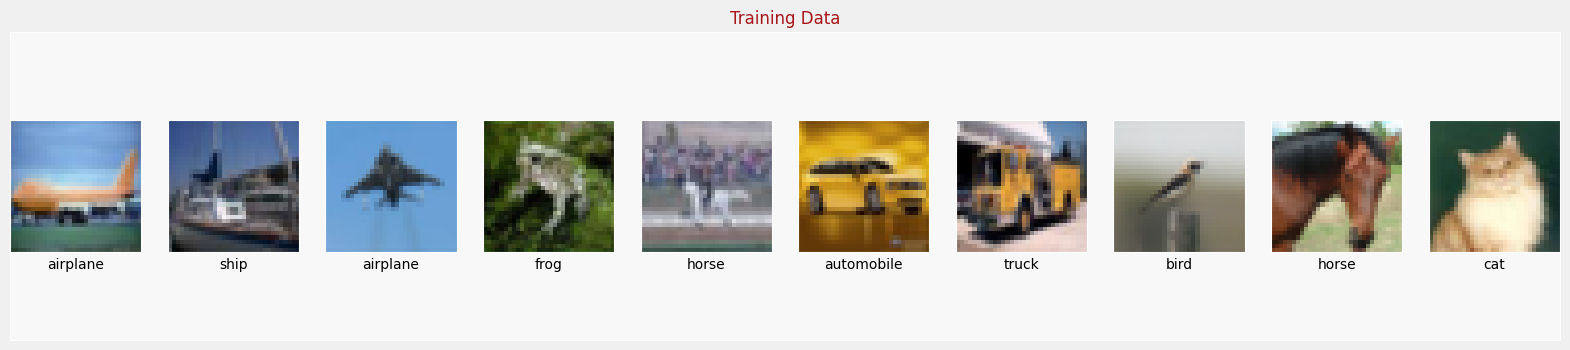

In [5]:
display_images(training_images, training_labels, training_labels, "Training Data" )

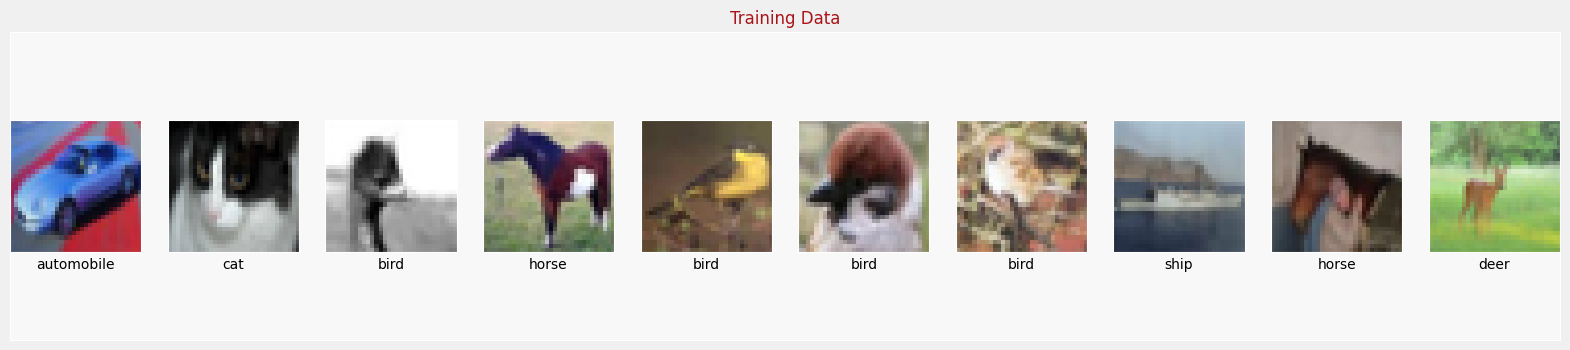

In [6]:
display_images(validation_images, validation_labels, validation_labels, "Training Data" )

### Preprocess Dataset
Here, we'll perform normalization on images in training and validation set. 
- We'll use the function [preprocess_input](https://github.com/keras-team/keras-applications/blob/master/keras_applications/resnet50.py) from the ResNet50 model in Keras.

In [7]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_ims


In [8]:
train_X = preprocess_image_input(training_images)
valid_X = preprocess_image_input(validation_images)

## Define the Network
We will be performing transfer learning on **ResNet50** available in Keras.
- We'll load pre-trained **imagenet weights** to the model.
- We'll choose to retain all layers of **ResNet50** along with the final classification layers.

In [20]:
'''
Feature Extraction is performed by ResNet50 pretrained on imagenet weights. 
Input size is 224 x 224.
'''
def feature_extractor(inputs):

  feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights=None)(inputs)
  return feature_extractor


'''
Defines final dense layers and subsequent softmax layer for classification.
'''
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

'''
Since input image size is (32 x 32), first upsample the image by factor of (7x7) to transform it to (224 x 224)
Connect the feature extraction and "classifier" layers to build the model.
'''
def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

'''
Define the model and compile it. 
Use Stochastic Gradient Descent as the optimizer.
Use Sparse Categorical CrossEntropy as the loss function.
'''
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model


model = define_compile_model()

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d_4 (UpSamplin  (None, 224, 224, 3)       0         
 g2D)                                                            
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_4  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dense_5 (Dense)             (None, 1024)              2098

In [19]:
# create data generators for cifar 10

(training_images, training_labels) , (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

image_generator.fit(training_images, augment=True)

train_generator = image_generator.flow(
    training_images, training_labels, batch_size=BATCH_SIZE)

model.fit(train_generator, epochs=30, validation_data=(validation_images, validation_labels), verbose=1)
# model.fit(training_images, training_labels, epochs=5, validation_data=(validation_images, validation_labels), verbose=1)

Epoch 1/30
1563/1563 [==============================] - 355s 227ms/step - loss: 1.9121 - accuracy: 0.2736 - val_loss: 2.1039 - val_accuracy: 0.2835
Epoch 2/30
1563/1563 [==============================] - 357s 228ms/step - loss: 1.7140 - accuracy: 0.3584 - val_loss: 2.1795 - val_accuracy: 0.3376
Epoch 3/30
1563/1563 [==============================] - 364s 233ms/step - loss: 1.5760 - accuracy: 0.4220 - val_loss: 1.5985 - val_accuracy: 0.4373
Epoch 4/30
1563/1563 [==============================] - 365s 233ms/step - loss: 1.4499 - accuracy: 0.4783 - val_loss: 1.3610 - val_accuracy: 0.5595
Epoch 5/30
1563/1563 [==============================] - 364s 233ms/step - loss: 1.3428 - accuracy: 0.5240 - val_loss: 1.5959 - val_accuracy: 0.5095
Epoch 6/30
1563/1563 [==============================] - 366s 234ms/step - loss: 1.2410 - accuracy: 0.5619 - val_loss: 1.2940 - val_accuracy: 0.5907
Epoch 7/30
1563/1563 [==============================] - 367s 235ms/step - loss: 1.1667 - accuracy: 0.5886 - val_

KeyboardInterrupt: 

## Train the model

In [12]:
EPOCHS = 64
history = model.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (valid_X, validation_labels), batch_size=32)

Epoch 1/64
1563/1563 [==============================] - 333s 213ms/step - loss: 0.9610 - accuracy: 0.6565 - val_loss: 0.9849 - val_accuracy: 0.6517
Epoch 2/64
1563/1563 [==============================] - 338s 216ms/step - loss: 0.8090 - accuracy: 0.7133 - val_loss: 0.8785 - val_accuracy: 0.6896
Epoch 3/64
1563/1563 [==============================] - 342s 219ms/step - loss: 0.6812 - accuracy: 0.7589 - val_loss: 0.7911 - val_accuracy: 0.7301
Epoch 4/64
1563/1563 [==============================] - 341s 218ms/step - loss: 0.5649 - accuracy: 0.8029 - val_loss: 0.9085 - val_accuracy: 0.7038
Epoch 5/64
1563/1563 [==============================] - 344s 220ms/step - loss: 0.4592 - accuracy: 0.8384 - val_loss: 1.0649 - val_accuracy: 0.6762
Epoch 6/64
1563/1563 [==============================] - 345s 221ms/step - loss: 0.3670 - accuracy: 0.8726 - val_loss: 1.0780 - val_accuracy: 0.6780
Epoch 7/64
1563/1563 [==============================] - 343s 220ms/step - loss: 0.2952 - accuracy: 0.8966 - val_

KeyboardInterrupt: 

## Evaluate the Model

Calculate the loss and accuracy metrics using the model's `.evaluate` function.

In [12]:
loss, accuracy = model.evaluate(valid_X, validation_labels, batch_size=64)

157/157 [==============================] - 16s 104ms/step - loss: 0.1810 - accuracy: 0.9478


### Plot Loss and Accuracy Curves

Plot the loss (in blue) and validation loss (in green).

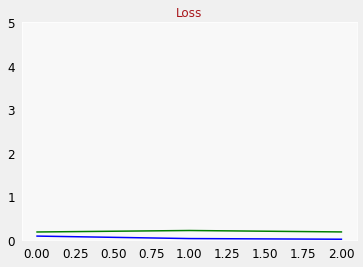

In [13]:
plot_metrics("loss", "Loss")

Plot the training accuracy (blue) as well as the validation accuracy (green).

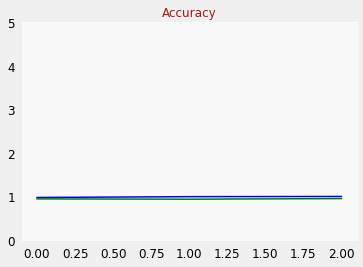

In [14]:
plot_metrics("accuracy", "Accuracy")

### Visualize predictions
We can take a look at the predictions on the validation set.

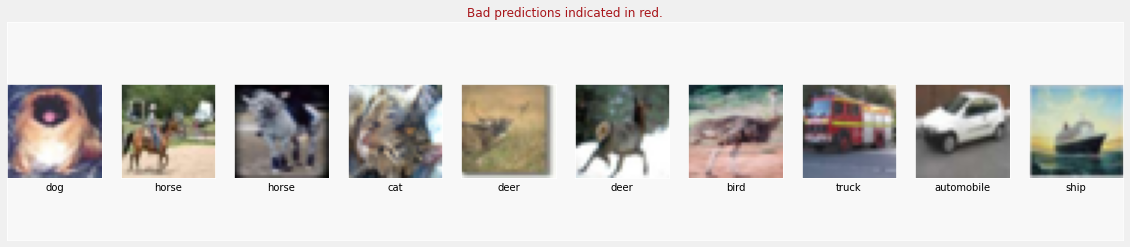

In [15]:
probabilities = model.predict(valid_X, batch_size=64)
probabilities = np.argmax(probabilities, axis = 1)

display_images(validation_images, probabilities, validation_labels, "Bad predictions indicated in red.")